In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import math
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import roc_auc_score
from itertools import compress
from sklearn.feature_selection import SequentialFeatureSelector

import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import f1_score

In [2]:
df = pd.read_csv('merged tables2.csv')
df = df.drop(columns = ['Unnamed: 0'], axis = 1)
df = df.dropna(axis=0).reset_index(drop=True)
df = df.drop_duplicates()

In [3]:
df

,carNum,operDate,operSt,operDestSt,operCargo,operWeight,real_dist,passed_dist,was_in_rep,msr_date,...,axle1_lf,axle2_rf,axle2_lf,axle3_rf,axle3_lf,axle4_rf,axle4_lf,days_in_operation,n_times_parts_in_repair,days_after_last_inspection
0,52600095,2021-08-01,30310,3160,23304,66.0,669.0,2236,0,2021-07-31,...,29.2,29.7,30.3,29.6,30.1,31.6,28.4,6331,40,0
1,52600095,2021-08-09,3000,28410,23304,0.0,1469.0,3997,0,2021-08-01,...,28.2,29.7,30.0,30.3,29.7,31.5,28.1,6339,40,7
2,52600095,2021-08-25,28430,9430,9407,60.0,2105.0,15915,0,2021-08-19,...,32.3,29.5,30.2,30.0,29.6,28.6,27.4,6355,40,6
3,92872498,2021-08-01,79300,89210,300,24.0,2171.0,7436,0,2021-07-29,...,29.2,29.6,27.6,29.4,29.3,26.1,31.3,601,10,2
4,92872498,2021-08-10,89020,98930,300,59.0,5155.0,7787,0,2021-08-03,...,29.1,29.5,27.7,29.7,29.4,26.4,30.8,610,10,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33834,59165787,2021-08-31,5630,15780,10307,0.0,600.0,85,0,2020-12-01,...,27.1,28.1,28.1,28.2,26.6,26.0,26.6,6433,20,273
33835,59166009,2021-08-31,5630,15780,10307,0.0,600.0,85,0,2021-06-20,...,29.2,31.2,30.3,30.5,30.8,29.3,26.6,6383,30,71
33836,59165308,2021-08-31,5630,15780,10307,0.0,600.0,85,0,2021-06-20,...,28.8,27.8,26.1,26.9,30.3,28.4,26.7,6676,20,71
33837,28065522,2021-08-31,65260,52100,48204,66.0,2299.0,80,0,2021-07-06,...,28.7,28.5,29.3,29.1,28.1,29.1,29.2,3106,50,56


In [4]:
df.columns

Index(['carNum', 'operDate', 'operSt', 'operDestSt', 'operCargo', 'operWeight',
       'real_dist', 'passed_dist', 'was_in_rep', 'msr_date', 'axle1_rf',
       'axle1_lf', 'axle2_rf', 'axle2_lf', 'axle3_rf', 'axle3_lf', 'axle4_rf',
       'axle4_lf', 'days_in_operation', 'n_times_parts_in_repair',
       'days_after_last_inspection'],
      dtype='object')

### Добавляю признаки:

In [5]:
df['avg_axle'] = df[['axle1_rf','axle1_lf', 
                                   'axle2_rf', 'axle2_lf', 'axle3_rf', 'axle3_lf', 
                                   'axle4_rf','axle4_lf']].mean(numeric_only=True, axis=1)

In [6]:
# оказалось уже есть

# df['operDate']=pd.to_datetime(df['operDate'], format='%Y-%m-%dT')
# df['msr_date']=pd.to_datetime(df['msr_date'], format='%Y-%m-%dT')

# df['days_on_road'] = (df['operDate']-df['msr_date']).dt.days

In [7]:
df

,carNum,operDate,operSt,operDestSt,operCargo,operWeight,real_dist,passed_dist,was_in_rep,msr_date,...,axle2_rf,axle2_lf,axle3_rf,axle3_lf,axle4_rf,axle4_lf,days_in_operation,n_times_parts_in_repair,days_after_last_inspection,avg_axle
0,52600095,2021-08-01,30310,3160,23304,66.0,669.0,2236,0,2021-07-31,...,29.7,30.3,29.6,30.1,31.6,28.4,6331,40,0,29.4875
1,52600095,2021-08-09,3000,28410,23304,0.0,1469.0,3997,0,2021-08-01,...,29.7,30.0,30.3,29.7,31.5,28.1,6339,40,7,29.4000
2,52600095,2021-08-25,28430,9430,9407,60.0,2105.0,15915,0,2021-08-19,...,29.5,30.2,30.0,29.6,28.6,27.4,6355,40,6,29.4750
3,92872498,2021-08-01,79300,89210,300,24.0,2171.0,7436,0,2021-07-29,...,29.6,27.6,29.4,29.3,26.1,31.3,601,10,2,28.7875
4,92872498,2021-08-10,89020,98930,300,59.0,5155.0,7787,0,2021-08-03,...,29.5,27.7,29.7,29.4,26.4,30.8,610,10,7,28.8000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33834,59165787,2021-08-31,5630,15780,10307,0.0,600.0,85,0,2020-12-01,...,28.1,28.1,28.2,26.6,26.0,26.6,6433,20,273,27.4875
33835,59166009,2021-08-31,5630,15780,10307,0.0,600.0,85,0,2021-06-20,...,31.2,30.3,30.5,30.8,29.3,26.6,6383,30,71,29.5750
33836,59165308,2021-08-31,5630,15780,10307,0.0,600.0,85,0,2021-06-20,...,27.8,26.1,26.9,30.3,28.4,26.7,6676,20,71,28.0000
33837,28065522,2021-08-31,65260,52100,48204,66.0,2299.0,80,0,2021-07-06,...,28.5,29.3,29.1,28.1,29.1,29.2,3106,50,56,28.8375


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29714 entries, 0 to 33838
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   carNum                      29714 non-null  int64  
 1   operDate                    29714 non-null  object 
 2   operSt                      29714 non-null  int64  
 3   operDestSt                  29714 non-null  int64  
 4   operCargo                   29714 non-null  int64  
 5   operWeight                  29714 non-null  float64
 6   real_dist                   29714 non-null  float64
 7   passed_dist                 29714 non-null  int64  
 8   was_in_rep                  29714 non-null  int64  
 9   msr_date                    29714 non-null  object 
 10  axle1_rf                    29714 non-null  float64
 11  axle1_lf                    29714 non-null  float64
 12  axle2_rf                    29714 non-null  float64
 13  axle2_lf                    297

In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df=df.sort_values(by=['operDate'])
df["operDate"] = le.fit_transform(df["operDate"])
df=df.sort_values(by=['msr_date'])
df["msr_date"] = le.fit_transform(df["msr_date"])
df.head()

,carNum,operDate,operSt,operDestSt,operCargo,operWeight,real_dist,passed_dist,was_in_rep,msr_date,...,axle2_rf,axle2_lf,axle3_rf,axle3_lf,axle4_rf,axle4_lf,days_in_operation,n_times_parts_in_repair,days_after_last_inspection,avg_axle
26696,59168815,13,4920,2190,10307,45.0,455.0,935,0,0,...,27.6,29.7,31.0,31.2,29.0,28.3,5940,40,1265,28.725
26698,59168815,27,4920,2190,10307,45.0,455.0,562,0,0,...,27.6,29.7,31.0,31.2,29.0,28.3,5954,40,1279,28.725
26697,59168815,19,2170,4930,42100,0.0,456.0,1357,0,0,...,27.6,29.7,31.0,31.2,29.0,28.3,5946,40,1271,28.725
26694,59168815,4,4930,2190,10307,45.0,483.0,1147,0,0,...,27.6,29.7,31.0,31.2,29.0,28.3,5931,40,1256,28.725
26695,59168815,9,2170,4930,42100,0.0,456.0,1375,0,0,...,27.6,29.7,31.0,31.2,29.0,28.3,5936,40,1261,28.725


In [10]:
operDestSt_nom = (df.groupby('operDestSt').size()) / len(df)
df['operDestSt'] = df['operDestSt'].apply(lambda x : operDestSt_nom[x])
operSt_nom = (df.groupby('operSt').size()) / len(df)
df['operSt'] = df['operSt'].apply(lambda x : operSt_nom[x])
operCargo_nom = (df.groupby('operCargo').size()) / len(df)
df['operCargo'] = df['operCargo'].apply(lambda x : operCargo_nom[x])

In [11]:
df.head()

,carNum,operDate,operSt,operDestSt,operCargo,operWeight,real_dist,passed_dist,was_in_rep,msr_date,...,axle2_rf,axle2_lf,axle3_rf,axle3_lf,axle4_rf,axle4_lf,days_in_operation,n_times_parts_in_repair,days_after_last_inspection,avg_axle
26696,59168815,13,0.001447,0.010399,0.026385,45.0,455.0,935,0,0,...,27.6,29.7,31.0,31.2,29.0,28.3,5940,40,1265,28.725
26698,59168815,27,0.001447,0.010399,0.026385,45.0,455.0,562,0,0,...,27.6,29.7,31.0,31.2,29.0,28.3,5954,40,1279,28.725
26697,59168815,19,0.015649,0.001481,0.006697,0.0,456.0,1357,0,0,...,27.6,29.7,31.0,31.2,29.0,28.3,5946,40,1271,28.725
26694,59168815,4,0.000774,0.010399,0.026385,45.0,483.0,1147,0,0,...,27.6,29.7,31.0,31.2,29.0,28.3,5931,40,1256,28.725
26695,59168815,9,0.015649,0.001481,0.006697,0.0,456.0,1375,0,0,...,27.6,29.7,31.0,31.2,29.0,28.3,5936,40,1261,28.725


<AxesSubplot:>

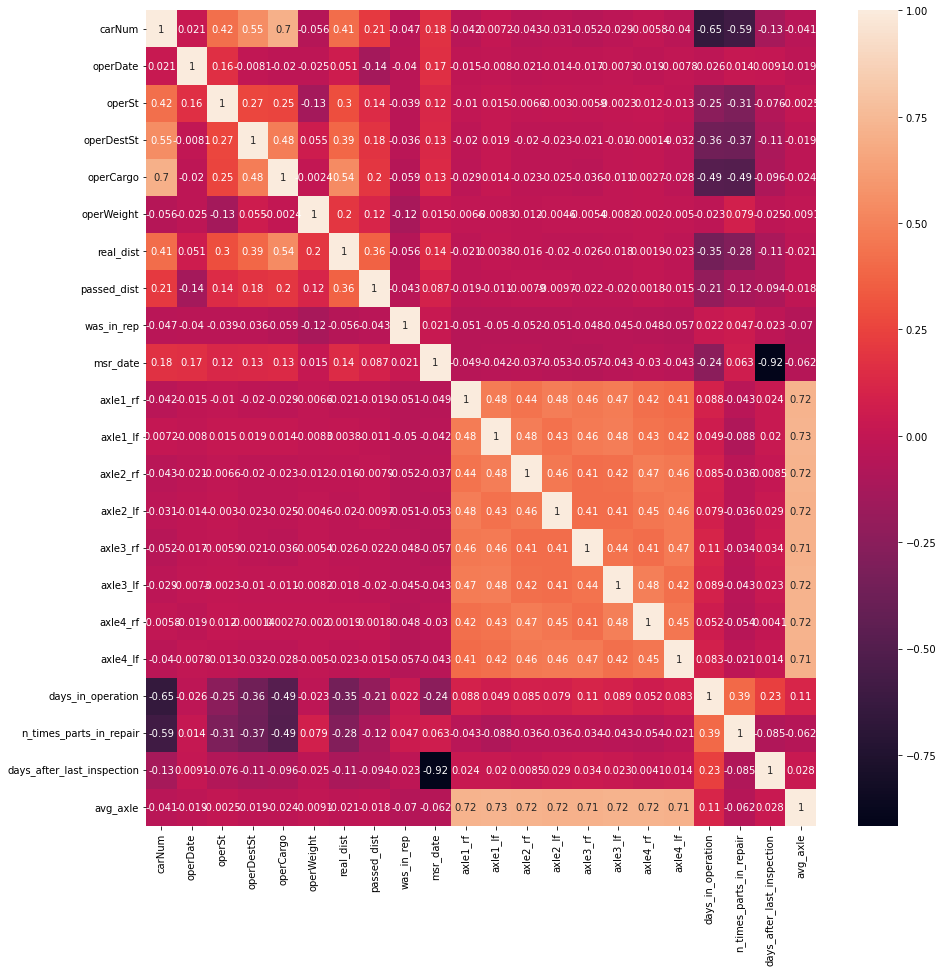

In [12]:
plt.subplots(figsize=(15,15))
sns.heatmap(df.corr(),annot=True)

In [13]:
# #перемешиваю данные
# was_in_rep=df[df['was_in_rep']==1].sample(frac=1) 

In [14]:
# not_in_rep=df[df['was_in_rep']==0].sample(frac=1) 

In [15]:
# df_was_30 = was_in_rep.iloc[:math.floor(len(was_in_rep)*0.3)]
# df_was_70 = was_in_rep.iloc[math.floor(len(was_in_rep)*0.3):]
# df_wasnt_30 = not_in_rep.iloc[:math.floor(len(not_in_rep)*0.3)]
# df_wasnt_70 = not_in_rep.iloc[math.floor(len(not_in_rep)*0.3):]

In [16]:
# print('Число единиц на контроль: ',len(df_was_30))
# print('Число единиц на обучение: ',len(df_was_70))
# print('Число нулей на контроль: ', len(df_wasnt_30))
# print('Число нулей на обучение: ',len(df_wasnt_70))

In [17]:
# df_test = pd.concat([df_was_30, df_wasnt_30]).sample(frac=1) 

In [18]:
# df_train = pd.concat([df_was_70, df_wasnt_70]).sample(frac=1) 

In [19]:
# df_train

In [20]:
# df_test

In [21]:
df.columns

Index(['carNum', 'operDate', 'operSt', 'operDestSt', 'operCargo', 'operWeight',
       'real_dist', 'passed_dist', 'was_in_rep', 'msr_date', 'axle1_rf',
       'axle1_lf', 'axle2_rf', 'axle2_lf', 'axle3_rf', 'axle3_lf', 'axle4_rf',
       'axle4_lf', 'days_in_operation', 'n_times_parts_in_repair',
       'days_after_last_inspection', 'avg_axle'],
      dtype='object')

In [22]:
columns_for_X=[ 'operDate', 'operSt', 'operDestSt', 'operCargo', 'operWeight',
       'real_dist', 'passed_dist', 'msr_date', 'axle1_rf',
       'axle1_lf', 'axle2_rf', 'axle2_lf', 'axle3_rf', 'axle3_lf', 'axle4_rf',
       'axle4_lf', 'days_in_operation', 'n_times_parts_in_repair',
       'days_after_last_inspection','avg_axle']

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[columns_for_X], df.was_in_rep, test_size=0.33, random_state=42)

In [24]:
y_train.value_counts()

0    19277
1      631
Name: was_in_rep, dtype: int64

In [25]:
y_test.value_counts()

0    9522
1     284
Name: was_in_rep, dtype: int64

In [103]:
(631+284)/(19277+9522)*100

3.1771936525573805

In [26]:
# columns_for_X=['carNum', 'operDate', 'operSt', 'operDestSt', 'operCargo', 'operWeight',
#        'real_dist', 'passed_dist', 'msr_date', 'axle1_rf',
#        'axle1_lf', 'axle2_rf', 'axle2_lf', 'axle3_rf', 'axle3_lf', 'axle4_rf',
#        'axle4_lf', 'days_in_operation', 'n_times_parts_in_repair',
#        'days_after_last_inspection']
# X_train = df_train[columns_for_X]
# X_test = df_test[columns_for_X]
# y_train = df_train['was_in_rep'].values
# y_test = df_test['was_in_rep'].values

In [27]:
def info(y_test,y_pred,y_pred_proba):
    confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('tn:',tn)
    print('fp:',fp)
    print('fn:',fn)
    print('tp:',tp)
    print(fr'Accuracy: {100 * accuracy_score(y_test, y_pred):.3f} %')
    print(fr'F1: {f1_score(y_test, y_pred):.3f}')
    print(fr'Roc_auc: {roc_auc_score(y_test, y_pred_proba[:,1]):.3f}')

In [28]:
def info_for_df(y_test,y_pred,y_pred_proba):
    confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return ([tn, fp, fn, tp,fr'{100 * accuracy_score(y_test, y_pred):.3f} %',fr'{f1_score(y_test, y_pred):.3f}', fr'{roc_auc_score(y_test, y_pred_proba[:,1]):.3f}'])

In [29]:
df=pd.DataFrame( columns=['Model', 'TN', 'FP', 'FN', 'TP', 'Accuracy','F1','Roc_auc'])
df

,Model,TN,FP,FN,TP,Accuracy,F1,Roc_auc


# Логистическая регрессия

In [30]:
from sklearn.linear_model import LogisticRegression

In [31]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold()

In [32]:
log = LogisticRegression(class_weight='balanced',random_state=1)
log.fit(X_train, y_train)
y_pred = log.predict(X_test)

y_pred_proba = log.predict_proba(X_test)

res = info_for_df(y_test,y_pred,y_pred_proba)
df=df.append({'Model':'LogisticRegression', 'TN':res[0], 'FP':res[1], 
              'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'F1':res[5],'Roc_auc':res[6]},ignore_index=True)

info(y_test,y_pred,y_pred_proba)

tn: 6238
fp: 3284
fn: 71
tp: 213
Accuracy: 65.786 %
F1: 0.113
Roc_auc: 0.742


In [33]:
sfs = SequentialFeatureSelector(log,scoring='roc_auc',cv= skf )
sfs.fit(X_train, y_train)
col=list(compress(X_train.columns, sfs.get_support()))
print('Признаки: ',col)

log = LogisticRegression(class_weight='balanced',random_state=1)
log.fit(X_train[col], y_train)
y_pred = log.predict(X_test[col])
y_pred_proba = log.predict_proba(X_test[col])


res = info_for_df(y_test,y_pred,y_pred_proba)
df=df.append({'Model':'LogisticRegression SFS (forward)', 'TN':res[0], 'FP':res[1], 
              'FN':res[2], 'TP':res[3], 'Accuracy':res[4],'F1':res[5],'Roc_auc':res[6]},ignore_index=True)

info(y_test,y_pred,y_pred_proba)

Признаки:  ['operDate', 'operSt', 'operDestSt', 'operCargo', 'operWeight', 'msr_date', 'axle1_lf', 'n_times_parts_in_repair', 'days_after_last_inspection', 'avg_axle']
tn: 6431
fp: 3091
fn: 71
tp: 213
Accuracy: 67.754 %
F1: 0.119
Roc_auc: 0.759


In [34]:
df

,Model,TN,FP,FN,TP,Accuracy,F1,Roc_auc
0,LogisticRegression,6238,3284,71,213,65.786 %,0.113,0.742
1,LogisticRegression SFS (forward),6431,3091,71,213,67.754 %,0.119,0.759


In [35]:
# sfs = SequentialFeatureSelector(log, direction='backward',scoring='roc_auc',cv= skf)
# sfs.fit(X_train, y_train)
# col=list(compress(X_train.columns, sfs.get_support()))
# print('Признаки: ',col)

# log = LogisticRegression(class_weight='balanced',random_state=1)
# log.fit(X_train[col], y_train)
# y_pred = log.predict(X_test[col])
# y_pred_proba = log.predict_proba(X_test[col])

# res = info_for_df(y_test,y_pred,y_pred_proba)
# df=df.append({'Model':'LogisticRegression SFS (backward)', 'TN':res[0], 'FP':res[1], 
#               'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'Roc_auc':res[5]},ignore_index=True)

# info(y_test,y_pred,y_pred_proba)

# SVM

In [36]:
from sklearn import svm

In [37]:
sv = svm.SVC(class_weight='balanced',random_state=1,probability=True)
sv.fit(X_train, y_train)
y_pred = sv.predict(X_test)
y_pred_proba = sv.predict_proba(X_test)

res = info_for_df(y_test,y_pred,y_pred_proba)
df=df.append({'Model':'SVM', 'TN':res[0], 'FP':res[1], 
              'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'F1':res[5],'Roc_auc':res[6]},ignore_index=True)

info(y_test,y_pred,y_pred_proba)

tn: 6845
fp: 2677
fn: 107
tp: 177
Accuracy: 71.609 %
F1: 0.113
Roc_auc: 0.737


In [38]:
# sfs = SequentialFeatureSelector(sv)
# sfs.fit(X_train, y_train)
# col=list(compress(X_train.columns, sfs.get_support()))

# sv = svm.SVC(class_weight='balanced',random_state=1)
# sv.fit(X_train, y_train)
# y_pred = sv.predict(X_test)

# info(y_test,y_pred)

In [39]:
# sfs = SequentialFeatureSelector(sv, direction='backward')
# sfs.fit(X_train, y_train)
# col=list(compress(X_train.columns, sfs.get_support()))

# sv = svm.SVC(class_weight='balanced',random_state=1)
# sv.fit(X_train, y_train)
# y_pred = sv.predict(X_test)

# info(y_test,y_pred)

# Деревья классификации

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [41]:
dt = DecisionTreeClassifier(max_depth=7,random_state=42,class_weight='balanced')
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
y_pred_proba = dt.predict_proba(X_test)


res = info_for_df(y_test,y_pred,y_pred_proba)
df=df.append({'Model':'DecisionTreeClassifier', 'TN':res[0], 'FP':res[1], 
              'FN':res[2], 'TP':res[3], 'Accuracy':res[4],'F1':res[5],'Roc_auc':res[6]},ignore_index=True)

info(y_test,y_pred,y_pred_proba)

tn: 7552
fp: 1970
fn: 84
tp: 200
Accuracy: 79.054 %
F1: 0.163
Roc_auc: 0.786


In [42]:
from sklearn.tree import export_graphviz

In [43]:
export_graphviz(dt, out_file='decision_tree2.dot', 
                filled=True,
                feature_names=['operDate', 'operSt', 'operDestSt', 'operCargo', 'operWeight', 'real_dist', 'passed_dist', 'msr_date', 'axle1_rf', 'axle1_lf', 'axle2_rf', 'axle2_lf', 'axle3_rf', 'axle3_lf', 'axle4_rf', 'axle4_lf', 'days_in_operation', 'n_times_parts_in_repair', 'days_after_last_inspection', 'avg_axle'],
                class_names=['0','1'])

In [44]:
# sfs = SequentialFeatureSelector(dt,scoring='roc_auc',cv= skf)
# sfs.fit(X_train, y_train)
# col=list(compress(X_train.columns, sfs.get_support()))
# print('Признаки: ',col)

# dt = DecisionTreeClassifier(max_depth=7,random_state=42,class_weight='balanced')
# dt.fit(X_train[col], y_train)
# y_pred = dt.predict(X_test[col])
# y_pred_proba = dt.predict_proba(X_test[col])

# res = info_for_df(y_test,y_pred,y_pred_proba)
# df=df.append({'Model':'DecisionTreeClassifier SFS (forward)', 'TN':res[0], 'FP':res[1], 
#               'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'Roc_auc':res[5]},ignore_index=True)

# info(y_test,y_pred,y_pred_proba)

In [45]:
# sfs = SequentialFeatureSelector(dt, direction='backward',scoring='roc_auc',cv= skf)
# sfs.fit(X_train, y_train)
# col=list(compress(X_train.columns, sfs.get_support()))
# print('Признаки: ',col)

# dt = DecisionTreeClassifier(max_depth=7,random_state=42,class_weight='balanced')
# dt.fit(X_train[col], y_train)
# y_pred = dt.predict(X_test[col])
# y_pred_proba = dt.predict_proba(X_test[col])

# res = info_for_df(y_test,y_pred,y_pred_proba)
# df=df.append({'Model':'DecisionTreeClassifier SFS (backward)', 'TN':res[0], 'FP':res[1], 
#               'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'Roc_auc':res[5]}, ignore_index=True)

# info(y_test,y_pred,y_pred_proba)

# KNN

In [46]:
from sklearn.neighbors import KNeighborsClassifier

In [47]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
y_pred_proba = knn.predict_proba(X_test)

res = info_for_df(y_test,y_pred,y_pred_proba)
df=df.append({'Model':'KNeighborsClassifier', 'TN':res[0], 'FP':res[1], 
              'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'F1':res[5],'Roc_auc':res[6]},ignore_index=True)

info(y_test,y_pred,y_pred_proba)

tn: 9287
fp: 235
fn: 224
tp: 60
Accuracy: 95.319 %
F1: 0.207
Roc_auc: 0.593


In [48]:
# sfs = SequentialFeatureSelector(knn,scoring='roc_auc',cv= skf)
# sfs.fit(X_train, y_train)
# col=list(compress(X_train.columns, sfs.get_support()))
# print('Признаки: ',col)

# knn = KNeighborsClassifier(n_neighbors=1)
# knn.fit(X_train[col], y_train)
# y_pred = knn.predict(X_test[col])
# y_pred_proba = knn.predict_proba(X_test[col])

# res = info_for_df(y_test,y_pred,y_pred_proba)
# df=df.append({'Model':'KNeighborsClassifier SFS (forward)', 'TN':res[0], 'FP':res[1], 
#               'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'Roc_auc':res[5]}, ignore_index=True)

# info(y_test,y_pred,y_pred_proba)

In [49]:
# sfs = SequentialFeatureSelector(knn, direction='backward',scoring='roc_auc',cv= skf)
# sfs.fit(X_train, y_train)
# col=list(compress(X_train.columns, sfs.get_support()))
# print('Признаки: ',col)

# knn = KNeighborsClassifier(n_neighbors=1)
# knn.fit(X_train[col], y_train)
# y_pred = knn.predict(X_test[col])
# y_pred_proba = knn.predict_proba(X_test[col])

# res = info_for_df(y_test,y_pred,y_pred_proba)
# df=df.append({'Model':'KNeighborsClassifier SFS (backward)', 'TN':res[0], 'FP':res[1], 
#               'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'Roc_auc':res[5]}, ignore_index=True)

# info(y_test,y_pred,y_pred_proba)

# IsolationForest

In [50]:
from sklearn.ensemble import IsolationForest

In [51]:
# isf = IsolationForest(max_features=10,n_estimators=190, contamination=0.034)
# isf.fit(X_train)
# y_pred_train = isf.predict(X_train)
# y_pred_test = isf.predict(X_test)
# y_pred_test1=np.where(y_pred_test==-1,1,0)


# confusion_matrix(y_test, y_pred_test1)
# tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test1).ravel()

# df=df.append({'Model':'IsolationForest', 'TN':tn, 'FP':fp, 
#               'FN':fn, 'TP':tp, 'Accuracy':accuracy_score(y_test, y_pred_test1), 'Roc_auc': '-'},ignore_index=True)

# print('tn:',tn)
# print('fp:',fp)
# print('fn:',fn)
# print('tp:',tp)
# print(fr'Accuracy: {100 * accuracy_score(y_test, y_pred_test1):.3f} %')



In [52]:
# sfs = SequentialFeatureSelector(isf,scoring='roc_auc',cv= skf)
# sfs.fit(X_train, y_train)
# col=list(compress(X_train.columns, sfs.get_support()))
# print('Признаки: ',col)


# isf = IsolationForest(max_features=10,n_estimators=190, contamination=0.034)
# isf.fit(X_train[col])
# y_pred_train = isf.predict(X_train[col])
# y_pred_test = isf.predict(X_test[col])
# y_pred_test1=np.where(y_pred_test==-1,1,0)

# confusion_matrix(y_test, y_pred_test1)
# tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test1).ravel()
# df=df.append({'Model':'IsolationForest SFS (forward)', 'TN':tn, 'FP':fp, 
#               'FN':fn, 'TP':tp, 'Accuracy':accuracy_score(y_test, y_pred_test1), 'Roc_auc': '-'},ignore_index=True)
# print('tn:',tn)
# print('fp:',fp)
# print('fn:',fn)
# print('tp:',tp)
# print(fr'Accuracy: {100 * accuracy_score(y_test, y_pred_test1):.3f} %')

In [53]:
# sfs = SequentialFeatureSelector(isf,scoring=list, direction='backward')
# sfs.fit(X_train, y_train)
# col=list(compress(X_train.columns, sfs.get_support()))
# print('Признаки: ',col)


# isf = IsolationForest(max_features=10,n_estimators=190, contamination=0.034)
# isf.fit(X_train[col])
# y_pred_train = isf.predict(X_train[col])
# y_pred_test = isf.predict(X_test[col])
# y_pred_test1=np.where(y_pred_test==-1,1,0)
# info(y_test,y_pred_test1)

# RandomForestClassifier

In [54]:
from sklearn.ensemble import RandomForestClassifier

In [55]:
rfc= RandomForestClassifier(max_depth=15, max_features=20,random_state=42,class_weight='balanced')
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
y_pred_proba = rfc.predict_proba(X_test)

res = info_for_df(y_test,y_pred,y_pred_proba)
df=df.append({'Model':'RandomForestClassifier', 'TN':res[0], 'FP':res[1], 
              'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'F1':res[5],'Roc_auc':res[6]}, ignore_index=True)

info(y_test,y_pred,y_pred_proba)

tn: 9177
fp: 345
fn: 176
tp: 108
Accuracy: 94.687 %
F1: 0.293
Roc_auc: 0.846


In [56]:
sfs = SequentialFeatureSelector(rfc,scoring='roc_auc',cv= skf)
sfs.fit(X_train, y_train)
col=list(compress(X_train.columns, sfs.get_support()))
print('Признаки: ',col)

rfc= RandomForestClassifier(max_depth=15, max_features=10,random_state=42,class_weight='balanced')
rfc.fit(X_train[col], y_train)
y_pred = rfc.predict(X_test[col])
y_pred_proba = rfc.predict_proba(X_test[col])

res = info_for_df(y_test,y_pred,y_pred_proba)
df=df.append({'Model':'RandomForestClassifier SFS (forward)', 'TN':res[0], 'FP':res[1], 
              'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'F1':res[5],'Roc_auc':res[6]}, ignore_index=True)

info(y_test,y_pred,y_pred_proba)

Признаки:  ['operDate', 'operSt', 'operDestSt', 'operCargo', 'operWeight', 'real_dist', 'passed_dist', 'msr_date', 'axle4_rf', 'days_after_last_inspection']
tn: 9227
fp: 295
fn: 163
tp: 121
Accuracy: 95.329 %
F1: 0.346
Roc_auc: 0.861


In [57]:
# sfs = SequentialFeatureSelector(rfc, direction='backward')
# sfs.fit(X_train, y_train)
# col=list(compress(X_train.columns, sfs.get_support()))
# print('Признаки: ',col)

# rfc= RandomForestClassifier(max_depth=15, max_features=20,random_state=42,class_weight='balanced')
# rfc.fit(X_train[col], y_train)
# y_pred = rfc.predict(X_test[col])

# info(y_test,y_pred)

# AdaBoostClassifier

In [58]:
from sklearn.ensemble import AdaBoostClassifier

In [59]:
abc = AdaBoostClassifier(algorithm='SAMME')
abc.fit(X_train, y_train)
y_pred = abc.predict(X_test)
y_pred_proba = abc.predict_proba(X_test)

res = info_for_df(y_test,y_pred,y_pred_proba)
df=df.append({'Model':'AdaBoostClassifier', 'TN':res[0], 'FP':res[1], 
              'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'F1':res[5],'Roc_auc':res[6]}, ignore_index=True)

info(y_test,y_pred,y_pred_proba)

tn: 9522
fp: 0
fn: 284
tp: 0
Accuracy: 97.104 %
F1: 0.000
Roc_auc: 0.810


In [60]:
# sfs = SequentialFeatureSelector(abc,scoring='roc_auc',cv= skf)
# sfs.fit(X_train, y_train)
# col=list(compress(X_train.columns, sfs.get_support()))
# print('Признаки: ',col)

# abc = AdaBoostClassifier(algorithm='SAMME')
# abc.fit(X_train[col], y_train)
# y_pred = abc.predict(X_test[col])
# y_pred_proba = abc.predict_proba(X_test[col])

# res = info_for_df(y_test,y_pred,y_pred_proba)
# df=df.append({'Model':'AdaBoostClassifier SFS (forward)', 'TN':res[0], 'FP':res[1], 
#               'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'Roc_auc':res[5]}, ignore_index=True)

# info(y_test,y_pred,y_pred_proba)

In [61]:
# sfs = SequentialFeatureSelector(abc, direction='backward')
# sfs.fit(X_train, y_train)
# col=list(compress(X_train.columns, sfs.get_support()))
# print('Признаки: ',col)

# abc = AdaBoostClassifier(algorithm='SAMME')
# abc.fit(X_train[col], y_train)
# y_pred = abc.predict(X_test[col])

# info(y_test,y_pred)

# ExtraTreesClassifier

In [62]:
from sklearn.ensemble import ExtraTreesClassifier

In [63]:
etc = ExtraTreesClassifier(random_state=42,class_weight='balanced',max_depth=16)
etc.fit(X_train, y_train)
y_pred = etc.predict(X_test)
y_pred_proba = etc.predict_proba(X_test)

res = info_for_df(y_test,y_pred,y_pred_proba)
df=df.append({'Model':'ExtraTreesClassifier', 'TN':res[0], 'FP':res[1], 
              'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'F1':res[5],'Roc_auc':res[6]}, ignore_index=True)

info(y_test,y_pred,y_pred_proba)

tn: 8501
fp: 1021
fn: 153
tp: 131
Accuracy: 88.028 %
F1: 0.182
Roc_auc: 0.812


In [64]:
sfs = SequentialFeatureSelector(etc,scoring='roc_auc',cv= skf)
sfs.fit(X_train, y_train)
col=list(compress(X_train.columns, sfs.get_support()))
print('Признаки: ',col)

etc = ExtraTreesClassifier(random_state=42,class_weight='balanced',max_depth=16)
etc.fit(X_train[col], y_train)
y_pred = etc.predict(X_test[col])
y_pred_proba = etc.predict_proba(X_test[col])

res = info_for_df(y_test,y_pred,y_pred_proba)
df=df.append({'Model':'ExtraTreesClassifier SFS (forward)', 'TN':res[0], 'FP':res[1], 
              'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'F1':res[5],'Roc_auc':res[6]}, ignore_index=True)

info(y_test,y_pred,y_pred_proba)

Признаки:  ['operDate', 'operSt', 'operDestSt', 'operCargo', 'operWeight', 'real_dist', 'passed_dist', 'msr_date', 'days_in_operation', 'days_after_last_inspection']
tn: 8391
fp: 1131
fn: 112
tp: 172
Accuracy: 87.324 %
F1: 0.217
Roc_auc: 0.844


In [65]:
# sfs = SequentialFeatureSelector(etc, direction='backward',scoring='roc_auc',cv= skf)
# sfs.fit(X_train, y_train)
# col=list(compress(X_train.columns, sfs.get_support()))
# print('Признаки: ',col)

# etc = ExtraTreesClassifier(random_state=42,class_weight='balanced',max_depth=16)
# etc.fit(X_train[col], y_train)
# y_pred = etc.predict(X_test[col])
# y_pred_proba = etc.predict_proba(X_test[col])

# res = info_for_df(y_test,y_pred,y_pred_proba)
# df=df.append({'Model':'ExtraTreesClassifier SFS (backward)', 'TN':res[0], 'FP':res[1], 
#               'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'Roc_auc':res[5]}, ignore_index=True)

# info(y_test,y_pred,y_pred_proba)

# BaggingClassifier

In [66]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC

In [67]:
bagging = BaggingClassifier(bootstrap_features=True)
bagging.fit(X_train, y_train)
y_pred = bagging.predict(X_test)
y_pred_proba = bagging.predict_proba(X_test)

res = info_for_df(y_test,y_pred,y_pred_proba)
df=df.append({'Model':'BaggingClassifier', 'TN':res[0], 'FP':res[1], 
              'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'F1':res[5],'Roc_auc':res[6]}, ignore_index=True)

info(y_test,y_pred,y_pred_proba)

tn: 9512
fp: 10
fn: 263
tp: 21
Accuracy: 97.216 %
F1: 0.133
Roc_auc: 0.735


In [68]:
sfs = SequentialFeatureSelector(bagging,scoring='roc_auc',cv= skf)
sfs.fit(X_train, y_train)
col=list(compress(X_train.columns, sfs.get_support()))
print('Признаки: ',col)

bagging = BaggingClassifier(bootstrap_features=True)
bagging.fit(X_train[col], y_train)
y_pred = bagging.predict(X_test[col])
y_pred_proba = bagging.predict_proba(X_test[col])

res = info_for_df(y_test,y_pred,y_pred_proba)
df=df.append({'Model':'BaggingClassifier SFS (forward)', 'TN':res[0], 'FP':res[1], 
              'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'F1':res[5],'Roc_auc':res[6]}, ignore_index=True)

info(y_test,y_pred,y_pred_proba)

Признаки:  ['operDate', 'operSt', 'operDestSt', 'operCargo', 'operWeight', 'real_dist', 'passed_dist', 'msr_date', 'days_in_operation', 'days_after_last_inspection']
tn: 9509
fp: 13
fn: 230
tp: 54
Accuracy: 97.522 %
F1: 0.308
Roc_auc: 0.756


In [69]:
# sfs = SequentialFeatureSelector(bagging, direction='backward',scoring='roc_auc',cv= skf)
# sfs.fit(X_train, y_train)
# col=list(compress(X_train.columns, sfs.get_support()))
# print('Признаки: ',col)

# bagging = BaggingClassifier(bootstrap_features=True)
# bagging.fit(X_train[col], y_train)
# y_pred = bagging.predict(X_test[col])
# y_pred_proba = bagging.predict_proba(X_test[col])

# res = info_for_df(y_test,y_pred,y_pred_proba)
# df=df.append({'Model':'BaggingClassifier SFS (backward)', 'TN':res[0], 'FP':res[1], 
#               'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'Roc_auc':res[5]}, ignore_index=True)


# info(y_test,y_pred,y_pred_proba)

# GradientBoostingClassifier

In [70]:
from sklearn.ensemble import GradientBoostingClassifier

In [71]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
y_pred = gbc.predict(X_test)
y_pred_proba = gbc.predict_proba(X_test)

res = info_for_df(y_test,y_pred,y_pred_proba)
df=df.append({'Model':'GradientBoostingClassifier', 'TN':res[0], 'FP':res[1], 
              'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'F1':res[5],'Roc_auc':res[6]}, ignore_index=True)

info(y_test,y_pred,y_pred_proba)

tn: 9506
fp: 16
fn: 252
tp: 32
Accuracy: 97.267 %
F1: 0.193
Roc_auc: 0.845


In [72]:
# sfs = SequentialFeatureSelector(gbc,scoring='roc_auc',cv= skf)
# sfs.fit(X_train, y_train)
# col=list(compress(X_train.columns, sfs.get_support()))
# print('Признаки: ',col)

# gbc = GradientBoostingClassifier()
# gbc.fit(X_train[col], y_train)
# y_pred = gbc.predict(X_test[col])
# y_pred_proba = gbc.predict_proba(X_test[col])

# res = info_for_df(y_test,y_pred,y_pred_proba)
# df=df.append({'Model':'GradientBoostingClassifier SFS (forward)', 'TN':res[0], 'FP':res[1], 
#               'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'Roc_auc':res[5]}, ignore_index=True)


# info(y_test,y_pred,y_pred_proba)

In [73]:
# sfs = SequentialFeatureSelector(gbc, direction='backward')
# sfs.fit(X_train, y_train)
# col=list(compress(X_train.columns, sfs.get_support()))
# print('Признаки: ',col)

# gbc = GradientBoostingClassifier()
# gbc.fit(X_train[col], y_train)
# y_pred = gbc.predict(X_test[col])

# info(y_test,y_pred)

# XGBoost

https://xgboost.readthedocs.io/en/stable/python/python_intro.html#scikit-learn-interface

In [74]:
import xgboost as xgb

In [75]:
xgbr = xgb.XGBClassifier()
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_test)
y_pred_proba = xgbr.predict_proba(X_test)

res = info_for_df(y_test,y_pred,y_pred_proba)
df=df.append({'Model':'XGBClassifier', 'TN':res[0], 'FP':res[1], 
              'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'F1':res[5],'Roc_auc':res[6]}, ignore_index=True)


info(y_test,y_pred,y_pred_proba)

tn: 9490
fp: 32
fn: 235
tp: 49
Accuracy: 97.277 %
F1: 0.268
Roc_auc: 0.864


In [76]:
sfs = SequentialFeatureSelector(xgbr,scoring='roc_auc',cv= skf)
sfs.fit(X_train, y_train)
col=list(compress(X_train.columns, sfs.get_support()))
print('Признаки: ',col)

xgbr = xgb.XGBClassifier()
xgbr.fit(X_train[col], y_train)
y_pred = xgbr.predict(X_test[col])
y_pred_proba = xgbr.predict_proba(X_test[col])

res = info_for_df(y_test,y_pred,y_pred_proba)
df=df.append({'Model':'XGBClassifier SFS (forward)', 'TN':res[0], 'FP':res[1], 
              'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'F1':res[5],'Roc_auc':res[6]}, ignore_index=True)

info(y_test,y_pred,y_pred_proba)

Признаки:  ['operDate', 'operSt', 'operDestSt', 'operCargo', 'operWeight', 'real_dist', 'passed_dist', 'axle1_lf', 'days_after_last_inspection', 'avg_axle']
tn: 9492
fp: 30
fn: 217
tp: 67
Accuracy: 97.481 %
F1: 0.352
Roc_auc: 0.874


In [77]:
sfs = SequentialFeatureSelector(xgbr, direction='backward',scoring='roc_auc',cv= skf)
sfs.fit(X_train, y_train)
col=list(compress(X_train.columns, sfs.get_support()))
print('Признаки: ',col)

xgbr = xgb.XGBClassifier()
xgbr.fit(X_train[col], y_train)
y_pred = xgbr.predict(X_test[col])
y_pred_proba = xgbr.predict_proba(X_test[col])

res = info_for_df(y_test,y_pred,y_pred_proba)
df=df.append({'Model':'XGBClassifier SFS (backward)', 'TN':res[0], 'FP':res[1], 
              'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'F1':res[5],'Roc_auc':res[6]}, ignore_index=True)

info(y_test,y_pred,y_pred_proba)

Признаки:  ['operDate', 'operSt', 'operDestSt', 'operCargo', 'operWeight', 'real_dist', 'passed_dist', 'msr_date', 'axle1_lf', 'days_after_last_inspection']
tn: 9485
fp: 37
fn: 207
tp: 77
Accuracy: 97.512 %
F1: 0.387
Roc_auc: 0.870


#  VotingClassifier

In [78]:
from sklearn.ensemble import  VotingClassifier

# DT+RFC+LOG

In [79]:
vc = VotingClassifier(estimators=[('DecisionTree', dt),
                                  ('rfc', rfc),
                                  ('log', log),], voting='soft')
vc = vc.fit(X_train, y_train)
y_pred = vc.predict(X_test)
y_pred_proba = vc.predict_proba(X_test)

res = info_for_df(y_test,y_pred,y_pred_proba)
df=df.append({'Model':'VotingClassifier(DT+RFC+LOG)', 'TN':res[0], 'FP':res[1], 
              'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'F1':res[5],'Roc_auc':res[6]}, ignore_index=True)

info(y_test,y_pred,y_pred_proba)

tn: 8279
fp: 1243
fn: 108
tp: 176
Accuracy: 86.223 %
F1: 0.207
Roc_auc: 0.828


In [80]:
# sfs = SequentialFeatureSelector(vc,scoring='roc_auc',cv= skf)
# sfs.fit(X_train, y_train)
# col=list(compress(X_train.columns, sfs.get_support()))
# print('Признаки: ',col)

# vc = VotingClassifier(estimators=[('DecisionTree', dt),
#                                   ('rfc', rfc),
#                                   ('log', log),], voting='soft')
# vc.fit(X_train[col], y_train)
# y_pred = vc.predict(X_test[col])
# y_pred_proba = vc.predict_proba(X_test[col])

# res = info_for_df(y_test,y_pred,y_pred_proba)
# df=df.append({'Model':'VotingClassifier(DecisionTree+RandomForest+LogReg) SFS (forward)', 'TN':res[0], 'FP':res[1], 
#               'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'Roc_auc':res[5]}, ignore_index=True)

# info(y_test,y_pred,y_pred_proba)

In [81]:
# sfs = SequentialFeatureSelector(vc, direction='backward')
# sfs.fit(X_train, y_train)
# col=list(compress(X_train.columns, sfs.get_support()))
# print('Признаки: ',col)

# vc = VotingClassifier(estimators=[('DecisionTree', dt),
#                                   ('rfc', rfc),
#                                   ('log', log),], voting='soft')
# vc.fit(X_train[col], y_train)
# y_pred = vc.predict(X_test[col])

# info(y_test,y_pred)

# RFC+ETC+GBC

In [82]:
vc = VotingClassifier(estimators=[('rfc', rfc),
                                  ('etc', etc),
                                 ('gbc', gbc)], voting='soft')
vc = vc.fit(X_train, y_train)
y_pred = vc.predict(X_test)
y_pred_proba = vc.predict_proba(X_test)

res = info_for_df(y_test,y_pred,y_pred_proba)
df=df.append({'Model':'VotingClassifier(RFC+ETC+GBC)', 'TN':res[0], 'FP':res[1], 
              'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'F1':res[5],'Roc_auc':res[6]}, ignore_index=True)

info(y_test,y_pred,y_pred_proba)

tn: 9430
fp: 92
fn: 220
tp: 64
Accuracy: 96.818 %
F1: 0.291
Roc_auc: 0.853


In [83]:
sfs = SequentialFeatureSelector(vc,scoring='roc_auc',cv= skf)
sfs.fit(X_train, y_train)
col=list(compress(X_train.columns, sfs.get_support()))
print('Признаки: ',col)

vc = VotingClassifier(estimators=[('rfc', rfc),
                                  ('etc', etc),
                                 ('gbc', gbc)], voting='soft')
vc.fit(X_train[col], y_train)
y_pred = vc.predict(X_test[col])
y_pred_proba = vc.predict_proba(X_test[col])

res = info_for_df(y_test,y_pred,y_pred_proba)
df=df.append({'Model':'VotingClassifier(RFC+ETC+GBC) SFS (forward)', 'TN':res[0], 'FP':res[1], 
              'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'F1':res[5],'Roc_auc':res[6]}, ignore_index=True)

info(y_test,y_pred,y_pred_proba)

Признаки:  ['operDate', 'operSt', 'operDestSt', 'operCargo', 'operWeight', 'real_dist', 'passed_dist', 'msr_date', 'days_in_operation', 'days_after_last_inspection']
tn: 9383
fp: 139
fn: 194
tp: 90
Accuracy: 96.604 %
F1: 0.351
Roc_auc: 0.867


# log+sv+dt+knn+rfc+abc+etc+gbc

In [84]:
vc = VotingClassifier(estimators=[('log', log),
                                  ('svm', sv),
                                  ('dt', dt),
                                 ('knn', knn),
                                  ('randomfor', rfc),
                                  ('ada', abc),
                                  ('extra', etc),
                                  ('gbc', gbc)
                                 ], voting='soft')
vc = vc.fit(X_train, y_train)
y_pred = vc.predict(X_test)
y_pred_proba = vc.predict_proba(X_test)

res = info_for_df(y_test,y_pred,y_pred_proba)
df=df.append({'Model':'VotingClassifier(LOG+SVM+DT+KNN+RFC+ADA+RFC+ETC+GBC)', 'TN':res[0], 'FP':res[1], 
              'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'F1':res[5],'Roc_auc':res[6]}, ignore_index=True)

info(y_test,y_pred,y_pred_proba)

tn: 9454
fp: 68
fn: 224
tp: 60
Accuracy: 97.022 %
F1: 0.291
Roc_auc: 0.844


# DT+RFC+ETC

In [85]:
vc = VotingClassifier(estimators=[('dt', dt),
                                  ('randomfor', rfc),
                                  ('extra', etc)
                                 ], voting='soft')
vc = vc.fit(X_train, y_train)
y_pred = vc.predict(X_test)
y_pred_proba = vc.predict_proba(X_test)

res = info_for_df(y_test,y_pred,y_pred_proba)
df=df.append({'Model':'VotingClassifier(DT+RFC+ETC)', 'TN':res[0], 'FP':res[1], 
              'FN':res[2], 'TP':res[3], 'Accuracy':res[4],'F1':res[5],'Roc_auc':res[6]}, ignore_index=True)

info(y_test,y_pred,y_pred_proba)

tn: 8693
fp: 829
fn: 128
tp: 156
Accuracy: 90.241 %
F1: 0.246
Roc_auc: 0.839


# GBC+ETC+xgbr

In [86]:
vc = VotingClassifier(estimators=[('gbc', gbc),
                                  ('etc', etc),
                                  ('xgbr', xgbr)
                                 ], voting='soft')
vc = vc.fit(X_train, y_train)
y_pred = vc.predict(X_test)
y_pred_proba = vc.predict_proba(X_test)

res = info_for_df(y_test,y_pred,y_pred_proba)
df=df.append({'Model':'VotingClassifier(GBC+etc+XGB)', 'TN':res[0], 'FP':res[1], 
              'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'F1':res[5],'Roc_auc':res[6]}, ignore_index=True)

info(y_test,y_pred,y_pred_proba)

tn: 9497
fp: 25
fn: 239
tp: 45
Accuracy: 97.308 %
F1: 0.254
Roc_auc: 0.856


In [87]:
sfs = SequentialFeatureSelector(vc,scoring='roc_auc',cv= skf)
sfs.fit(X_train, y_train)
col=list(compress(X_train.columns, sfs.get_support()))
print('Признаки: ',col)

vc = VotingClassifier(estimators=[('gbc', gbc),
                                  ('etc', etc),
                                  ('xgbr', xgbr)
                                 ], voting='soft')
vc.fit(X_train[col], y_train)
y_pred = vc.predict(X_test[col])
y_pred_proba = vc.predict_proba(X_test[col])

res = info_for_df(y_test,y_pred,y_pred_proba)
df=df.append({'Model':'VotingClassifier(GBC+etc+XGB) SFS (forward)', 'TN':res[0], 'FP':res[1], 
              'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'F1':res[5],'Roc_auc':res[6]}, ignore_index=True)

info(y_test,y_pred,y_pred_proba)

Признаки:  ['operDate', 'operSt', 'operDestSt', 'operCargo', 'operWeight', 'real_dist', 'passed_dist', 'msr_date', 'days_in_operation', 'days_after_last_inspection']
tn: 9496
fp: 26
fn: 218
tp: 66
Accuracy: 97.512 %
F1: 0.351
Roc_auc: 0.865


In [88]:
# sfs = SequentialFeatureSelector(vc,scoring='roc_auc',cv= skf,direction='backward')
# sfs.fit(X_train, y_train)
# col=list(compress(X_train.columns, sfs.get_support()))
# print('Признаки: ',col)

# vc = VotingClassifier(estimators=[('gbc', gbc),
#                                   ('etc', etc),
#                                   ('xgbr', xgbr),
#                                  ], voting='soft')
# vc.fit(X_train[col], y_train)
# y_pred = vc.predict(X_test[col])
# y_pred_proba = vc.predict_proba(X_test[col])

# res = info_for_df(y_test,y_pred,y_pred_proba)
# df=df.append({'Model':'VotingClassifier(DecisionTree+RandomForest+LogReg) SFS (backward)', 'TN':res[0], 'FP':res[1], 
#               'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'Roc_auc':res[5]}, ignore_index=True)

# info(y_test,y_pred,y_pred_proba)

# RFC+ETC+xgbr

In [89]:
vc = VotingClassifier(estimators=[('etc', etc),
                                  ('randomfor', rfc),
                                  ('xgbr', xgbr)
                                 ], voting='soft')
vc = vc.fit(X_train, y_train)
y_pred = vc.predict(X_test)
y_pred_proba = vc.predict_proba(X_test)

res = info_for_df(y_test,y_pred,y_pred_proba)
df=df.append({'Model':'VotingClassifier(ETC+RFC+XGB)', 'TN':res[0], 'FP':res[1], 
              'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'F1':res[5],'Roc_auc':res[6]}, ignore_index=True)

info(y_test,y_pred,y_pred_proba)

tn: 9424
fp: 98
fn: 213
tp: 71
Accuracy: 96.828 %
F1: 0.313
Roc_auc: 0.858


In [90]:
sfs = SequentialFeatureSelector(vc,scoring='roc_auc',cv= skf)
sfs.fit(X_train, y_train)
col=list(compress(X_train.columns, sfs.get_support()))
print('Признаки: ',col)

vc = VotingClassifier(estimators=[('etc', etc),
                                  ('randomfor', rfc),
                                  ('xgbr', xgbr)
                                 ], voting='soft')
vc.fit(X_train[col], y_train)
y_pred = vc.predict(X_test[col])
y_pred_proba = vc.predict_proba(X_test[col])

res = info_for_df(y_test,y_pred,y_pred_proba)
df=df.append({'Model':'VotingClassifier(ETC+RFC+XGB) SFS (forward)', 'TN':res[0], 'FP':res[1], 
              'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'F1':res[5],'Roc_auc':res[6]}, ignore_index=True)

info(y_test,y_pred,y_pred_proba)

Признаки:  ['operDate', 'operSt', 'operDestSt', 'operCargo', 'operWeight', 'real_dist', 'passed_dist', 'msr_date', 'days_in_operation', 'days_after_last_inspection']
tn: 9385
fp: 137
fn: 180
tp: 104
Accuracy: 96.767 %
F1: 0.396
Roc_auc: 0.869


# RFC+xgbr

In [91]:
vc = VotingClassifier(estimators=[('randomfor', rfc),
                                  ('xgbr', xgbr)
                                 ], voting='soft')
vc = vc.fit(X_train, y_train)
y_pred = vc.predict(X_test)
y_pred_proba = vc.predict_proba(X_test)

res = info_for_df(y_test,y_pred,y_pred_proba)
df=df.append({'Model':'VotingClassifier(RFC+XGB)', 'TN':res[0], 'FP':res[1], 
              'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'F1':res[5],'Roc_auc':res[6]}, ignore_index=True)

info(y_test,y_pred,y_pred_proba)

tn: 9468
fp: 54
fn: 224
tp: 60
Accuracy: 97.165 %
F1: 0.302
Roc_auc: 0.866


In [92]:
sfs = SequentialFeatureSelector(vc,scoring='roc_auc',cv= skf)
sfs.fit(X_train, y_train)
col=list(compress(X_train.columns, sfs.get_support()))
print('Признаки: ',col)

vc = VotingClassifier(estimators=[('randomfor', rfc),
                                  ('xgbr', xgbr)
                                 ], voting='soft')
vc.fit(X_train[col], y_train)
y_pred = vc.predict(X_test[col])
y_pred_proba = vc.predict_proba(X_test[col])

res = info_for_df(y_test,y_pred,y_pred_proba)
df=df.append({'Model':'VotingClassifier(RFC+XGB) SFS (forward)', 'TN':res[0], 'FP':res[1], 
              'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'F1':res[5],'Roc_auc':res[6]}, ignore_index=True)

info(y_test,y_pred,y_pred_proba)

Признаки:  ['operDate', 'operSt', 'operDestSt', 'operCargo', 'operWeight', 'real_dist', 'passed_dist', 'msr_date', 'axle4_rf', 'days_after_last_inspection']
tn: 9450
fp: 72
fn: 194
tp: 90
Accuracy: 97.287 %
F1: 0.404
Roc_auc: 0.873


# GBC+RFC+xgbr

In [93]:
vc = VotingClassifier(estimators=[('gbc', gbc),
                                  ('randomfor', rfc),
                                  ('xgbr', xgbr)
                                 ], voting='soft')
vc = vc.fit(X_train, y_train)
y_pred = vc.predict(X_test)
y_pred_proba = vc.predict_proba(X_test)

res = info_for_df(y_test,y_pred,y_pred_proba)
df=df.append({'Model':'VotingClassifier(GBC+RFC+XGB)', 'TN':res[0], 'FP':res[1], 
              'FN':res[2], 'TP':res[3], 'Accuracy':res[4],'F1':res[5],'Roc_auc':res[6]}, ignore_index=True)

info(y_test,y_pred,y_pred_proba)

tn: 9502
fp: 20
fn: 234
tp: 50
Accuracy: 97.410 %
F1: 0.282
Roc_auc: 0.871


In [94]:
sfs = SequentialFeatureSelector(vc,scoring='roc_auc',cv= skf)
sfs.fit(X_train, y_train)
col=list(compress(X_train.columns, sfs.get_support()))
print('Признаки: ',col)

vc = VotingClassifier(estimators=[('gbc', gbc),
                                  ('randomfor', rfc),
                                  ('xgbr', xgbr)
                                 ], voting='soft')
vc.fit(X_train[col], y_train)
y_pred = vc.predict(X_test[col])
y_pred_proba = vc.predict_proba(X_test[col])

res = info_for_df(y_test,y_pred,y_pred_proba)
df=df.append({'Model':'VotingClassifier(GBC+RFC+XGB)  SFS (forward)', 'TN':res[0], 'FP':res[1], 
              'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'F1':res[5],'Roc_auc':res[6]}, ignore_index=True)

info(y_test,y_pred,y_pred_proba)

Признаки:  ['operDate', 'operSt', 'operDestSt', 'operCargo', 'operWeight', 'real_dist', 'passed_dist', 'msr_date', 'axle4_rf', 'days_after_last_inspection']
tn: 9489
fp: 33
fn: 221
tp: 63
Accuracy: 97.410 %
F1: 0.332
Roc_auc: 0.875


# GBC+RFC+xgbr+LogReg

In [95]:
vc = VotingClassifier(estimators=[('gbc', gbc),
                                  ('randomfor', rfc),
                                  ('xgbr', xgbr),
                                  ('log', log)
                                 ], voting='soft')
vc = vc.fit(X_train, y_train)
y_pred = vc.predict(X_test)
y_pred_proba = vc.predict_proba(X_test)

res = info_for_df(y_test,y_pred,y_pred_proba)
df=df.append({'Model':'VotingClassifier(GBC+RFC+XGB+LogReg)', 'TN':res[0], 'FP':res[1], 
              'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'F1':res[5],'Roc_auc':res[6]}, ignore_index=True)

info(y_test,y_pred,y_pred_proba)

tn: 9477
fp: 45
fn: 221
tp: 63
Accuracy: 97.287 %
F1: 0.321
Roc_auc: 0.843


In [96]:
sfs = SequentialFeatureSelector(vc,scoring='roc_auc',cv= skf)
sfs.fit(X_train, y_train)
col=list(compress(X_train.columns, sfs.get_support()))
print('Признаки: ',col)

vc = VotingClassifier(estimators=[('gbc', gbc),
                                  ('log', log),
                                  ('randomfor', rfc),
                                  ('xgbr', xgbr)
                                 ], voting='soft')
vc.fit(X_train[col], y_train)
y_pred = vc.predict(X_test[col])
y_pred_proba = vc.predict_proba(X_test[col])

res = info_for_df(y_test,y_pred,y_pred_proba)
df=df.append({'Model':'VotingClassifier(GBC+RFC+XGB+LogReg)  SFS (forward)', 'TN':res[0], 'FP':res[1], 
              'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'F1':res[5],'Roc_auc':res[6]}, ignore_index=True)

info(y_test,y_pred,y_pred_proba)

Признаки:  ['operDate', 'operSt', 'operDestSt', 'operCargo', 'operWeight', 'real_dist', 'passed_dist', 'msr_date', 'n_times_parts_in_repair', 'days_after_last_inspection']
tn: 9475
fp: 47
fn: 203
tp: 81
Accuracy: 97.451 %
F1: 0.393
Roc_auc: 0.855


In [97]:
# sfs = SequentialFeatureSelector(vc,scoring='roc_auc',cv= skf, direction='backward')
# sfs.fit(X_train, y_train)
# col=list(compress(X_train.columns, sfs.get_support()))
# print('Признаки: ',col)

# vc = VotingClassifier(estimators=[('gbc', gbc),
#                                   ('randomfor', rfc),
#                                   ('xgbr', xgbr),
#                                  ], voting='soft')
# vc.fit(X_train[col], y_train)
# y_pred = vc.predict(X_test[col])
# y_pred_proba = vc.predict_proba(X_test[col])

# res = info_for_df(y_test,y_pred,y_pred_proba)
# df=df.append({'Model':'VotingClassifier(GBC+RFC+XGB)  SFS (forward)', 'TN':res[0], 'FP':res[1], 
#               'FN':res[2], 'TP':res[3], 'Accuracy':res[4], 'Roc_auc':res[5]}, ignore_index=True)

# info(y_test,y_pred,y_pred_proba)

# Отбор признаков

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html

In [98]:
df

,Model,TN,FP,FN,TP,Accuracy,F1,Roc_auc
0,LogisticRegression,6238,3284,71,213,65.786 %,0.113,0.742
1,LogisticRegression SFS (forward),6431,3091,71,213,67.754 %,0.119,0.759
2,SVM,6845,2677,107,177,71.609 %,0.113,0.737
3,DecisionTreeClassifier,7552,1970,84,200,79.054 %,0.163,0.786
4,KNeighborsClassifier,9287,235,224,60,95.319 %,0.207,0.593
5,RandomForestClassifier,9177,345,176,108,94.687 %,0.293,0.846
6,RandomForestClassifier SFS (forward),9227,295,163,121,95.329 %,0.346,0.861
7,AdaBoostClassifier,9522,0,284,0,97.104 %,0.000,0.810
8,ExtraTreesClassifier,8501,1021,153,131,88.028 %,0.182,0.812
9,ExtraTreesClassifier SFS (forward),8391,1131,112,172,87.324 %,0.217,0.844


In [99]:
df.to_csv('info4.csv')